# Timely and Effective Care

We're entering an awesome era where open source and open datasets allow many more people to tackle life's challenges, including healthcare. What once required teams of researchers can now be done by a few people with coffee and laptops. 

The Center for Medicare and Medicaid Services (CMS) has made many datasets available, including a data set tracking hospitals' ability to provide timely and effective care across various use cases. 

Timely and Effective care is measured by the percent of patients who meet certain quality metrics, such as whether or not patients got key drugs within 30 minutes of their hospital visit. These are scored by "measures", and you can get detailed descriptions of those measures here: [Timely and Effective Care](https://www.medicare.gov/hospitalcompare/about/timely-effective-care.html)

This study seeks to explore what characteristics lead to timely and effective care. Health systems can potentially use this information to make smarter investments in quality and safety.

This work will be done in three phases:
- Preprocessing & EDA (current)
- Analysis and Predictive Modeling
- Presentation & Publication (interactive charting)

### Note before attempting to use this notebook

Make sure you have the libraries you see below installed! Additionally, this pulls from Medicare's Data API. You'll need to use [this page](https://dev.socrata.com/foundry/data.medicare.gov/3z8n-wcgr) to obtain access to the data without throttling limits. However, the present code is just fine for this project, as it doesn't presently depend on fast or repeat access to the data. 

In [23]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sodapy import Socrata
import re
import seaborn as sns

import pandas_bokeh
pandas_bokeh.output_notebook()

plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 500)
pd.set_option('max_colwidth', 500)

Loading BokehJS ...

In [24]:
#Function to import Medicare data tables

def medicare_importer(token, password, user_name, medicare_data, data_code, limit):
    '''Importer for Medicare Data API. Takes in token, password, user_name, medicare_data, data_code, and limit
       to return a DataFrame for a given table.
       
       Socrata is the mechanism that returns data. Make sure to import Socrata before running this funtion.
       
       token(str) = your app token
       password(str) = your app password
       user_name(str) = your user name
       medicare_data(str) = likely data.medicare.gov but may vary
       data_code(str) = the code for a specific table. For instance, Timely & Effective Care is 3z8n-wcgr.
       limit(int) = the maximum number of rows you would like to grab. Defaults to 1000, so adjust upwards for complete data sets.
       '''
    
    #call Socrata to connect to Medicare data
    client = Socrata(medicare_data,
                     token,
                     username=user_name,
                     password=password)
    
    return pd.DataFrame(client.get(data_code, limit=limit)) #return relevant dataframe

In [25]:
#Import data for timely & effective care

app_token = ''
app_password = ''
user_name = ''
medicare_data = "data.medicare.gov"
timely_effective_care = "3z8n-wcgr"

te_data = medicare_importer(app_token, app_password, user_name, medicare_data, timely_effective_care, 120000)

#reorder columns
te_data = te_data[['address', 'city', 'state', 'zip_code', 'county_name', 'hospital_name', 'provider_id', 'location', 
                   'location_address', 'location_city', 'location_state', 'condition','footnote', 'measure_start_date', 
                   'measure_end_date', 'measure_id', 'measure_name', 'phone_number',  'sample', 'score']] 
te_data.head()

,address,city,state,zip_code,county_name,hospital_name,provider_id,location,location_address,location_city,location_state,condition,footnote,measure_start_date,measure_end_date,measure_id,measure_name,phone_number,sample,score
0,506 LENOX AVENUE,NEW YORK,NY,10037,NEW YORK,HARLEM HOSPITAL CENTER,330240,"{'type': 'Point', 'coordinates': [-73.940495, 40.814482]}",506 LENOX AVENUE,NEW YORK,NY,Emergency Department,NaN,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,2124918400,70281,7
1,PO BOX 287,BETHEL,AK,99559,BETHEL,YUKON KUSKOKWIM DELTA REG HOSPITAL,020018,NaN,PO BOX 287,BETHEL,AK,Emergency Department,5 - Results are not available for this reporting period.,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,9075436300,Not Available,Not Available
2,PO BOX 287,BETHEL,AK,99559,BETHEL,YUKON KUSKOKWIM DELTA REG HOSPITAL,020018,NaN,PO BOX 287,BETHEL,AK,Emergency Department,5 - Results are not available for this reporting period.,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,EDV,Emergency department volume,9075436300,NaN,Not Available
3,4420 LAKE BOONE TRAIL,RALEIGH,NC,27607,WAKE,REX HOSPITAL,340114,"{'type': 'Point', 'coordinates': [-78.705032, 35.815458]}",4420 LAKE BOONE TRAIL,RALEIGH,NC,Emergency Department,NaN,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,9197843100,60698,2
4,2525 COURT DR,GASTONIA,NC,28052,GASTON,CAROMONT REGIONAL MEDICAL CENTER,340032,"{'type': 'Point', 'coordinates': [-81.143023, 35.274593]}",2525 COURT DR,GASTONIA,NC,Preventive Care,2 - Data submitted were based on a sample of cases/patients.,2016-10-01T00:00:00.000,2017-03-31T00:00:00.000,IMM_2,Immunization for influenza,7048344891,566,98


In [26]:
te_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110239 entries, 0 to 110238
Data columns (total 20 columns):
address               110239 non-null object
city                  110239 non-null object
state                 110239 non-null object
zip_code              110239 non-null object
county_name           109894 non-null object
hospital_name         110239 non-null object
provider_id           110239 non-null object
location              101522 non-null object
location_address      110239 non-null object
location_city         110239 non-null object
location_state        110239 non-null object
condition             110239 non-null object
footnote              67791 non-null object
measure_start_date    110239 non-null object
measure_end_date      110239 non-null object
measure_id            110239 non-null object
measure_name          110239 non-null object
phone_number          110239 non-null object
sample                105446 non-null object
score                 110239 non-nu

As it was sent, this data set has no numeric datatypes. We would expect the score to be a numeric type. Let's explore what prevented this from happening. 

In [27]:
te_data.score.unique() #Interesting what gets included in score. There is a high variance of numbers in the scoring here because each score represents a different quality measure, and each quality measure is different

array(['7', 'Not Available', '2', '98', '31', '97', '4', '85', '0', '99',
       '1', 'Medium (20,000 - 39,999 patients annually)',
       'Low (0 - 19,999 patients annually)', '94', '37', '92', '50', '23',
       '79', 'High (40,000 - 59,999 patients annually)', '25', '100', '6',
       '91', '86', '3', '95', '24', '5', '96', '87', '93', '77', '17',
       '73', '71', '76', '44', '56', '72', '64', '54', '88', '90', '65',
       '19', '59', '81', '83', '80', '74', '70', '53', '89', '78', '84',
       '62', '82', '69', '52', '39', '38', '67', '29', '21', '60', '41',
       '9', '66', '68', '30', '11', '28', '48', '75', '33', '46', '49',
       '55', '45', '58', '61', '43', '57', '10', '8', '22', '42', '63',
       '32', '40', '20', '35', '51', '16', '47', '12', '34', '18', '26',
       '15', '14', '36', '13', '27', '113', '229', '199', '288', '130',
       '318', '241', '251', '305', '155', '273', '232', '189', '139',
       '138', '167', '106', '143', '279', '142', '156', '340', '270',

In [28]:
import re #needed for deeper text analysis

letter_finder = r'[A-Za-z]' #regex pattern to identify non-numeric values in strings
has_letters = te_data.score.str.contains(letter_finder) #filter using that pattern
te_data.loc[has_letters].score.value_counts() #Counts of these non-numeric values

Not Available                                 52164
Low (0 - 19,999 patients annually)             1303
Medium (20,000 - 39,999 patients annually)      962
Very High 60,000+ patients annually             699
High (40,000 - 59,999 patients annually)        603
Name: score, dtype: int64

In [29]:
te_data.score.str.contains(letter_finder).value_counts() 

True     55731
False    54508
Name: score, dtype: int64

Based on the observations above, we learn two things:
- More than 50% of the data is non-numeric
- Close to 50% of scores are not available

The impact here will vary depending on the measure we're studying. 

We want to figure out characteristics of these data to determine what to do with 
1. Missing values  
2. Categorical values

## Missing Values

How many values are missing by state?

In [30]:
score_not_available = te_data.score.str.contains('Not') #filter to the not available values

((te_data.loc[score_not_available].groupby('state')['score'].count()\
  /te_data.groupby('state')['score'].count())*100).sort_values(ascending=False)

state
MP    100.000000
AS    100.000000
GU     89.130435
PR     88.879599
VI     82.608696
SD     76.461769
MT     70.967742
ND     69.861660
AK     67.984190
ID     66.666667
KS     65.632992
VT     62.111801
WY     61.180124
IA     59.220390
NE     58.768930
HI     58.223062
MS     57.665904
LA     55.535258
OK     54.436197
CO     53.532609
TX     52.056979
NM     51.537646
NV     49.316770
WA     48.212560
MO     48.136646
AZ     47.881828
MN     47.424749
AR     46.840580
UT     46.691871
CA     44.995537
WV     44.897959
WI     44.720497
NH     43.478261
KY     43.048256
IL     42.560386
OH     42.404092
OR     41.304348
ME     41.238472
IN     40.289855
MI     40.092931
PA     39.715230
GA     39.690382
AL     39.082656
DE     38.509317
FL     38.445180
DC     38.043478
TN     37.962963
MD     37.622005
NY     36.649616
SC     36.304348
CT     35.203366
MA     35.127674
NC     34.989648
VA     34.833760
NJ     31.818182
RI     31.620553
Name: score, dtype: float64

The greatest incident of "Not available" is in non-US states. Let's see if there's anything interesting of note by measure. 

In [31]:
#Here are the measures and their values, notice a trend?
total_measures = te_data.measure_name.value_counts()
score_available_measures = te_data.loc[(score_not_available == False), 'measure_name'].value_counts()
score_available_measures_percent = ((score_available_measures/total_measures) * 100)

measures_records = pd.DataFrame({'available_records': score_available_measures, 
                                 'total': total_measures, 
                                 'percent_available': score_available_measures_percent}).sort_values(by='percent_available', ascending=False)
measures_records

,available_records,total,percent_available
Healthcare workers given influenza vaccination,4257,4793,88.817025
Immunization for influenza,4154,4793,86.668058
ED1,3919,4793,81.765074
ED2,3886,4793,81.076570
Door to diagnostic eval,3816,4793,79.616107
OP 18,3812,4793,79.532652
Median time to pain med,3602,4793,75.151262
Emergency department volume,3567,4793,74.421031
Left before being seen,3560,4793,74.274984
Appropriate care for severe sepsis and septic shock,3070,4793,64.051742


# The Measures We Should Measure

In [32]:
#Find needed number of samples for a given measure
corchrans_formula = ((1.96**2)*.5*.5)/(.05**2) #filter to ensure we're grabbing appropriate sample size
print('For a 95% confidence, Corchran\'s formula tells us we need {} samples, so we\'ll keep only rows where we have sufficient data.'.format(corchrans_formula))

For a 95% confidence, Corchran's formula tells us we need 384.1599999999999 samples, so we'll keep only rows where we have sufficient data.


In [33]:
#This creates a dataframe indicating which measures we should measure
measures_records_use = measures_records.loc[measures_records.available_records > corchrans_formula].reset_index(drop=False).rename(columns={'index': 'measure'})
measures_records_use

,measure,available_records,total,percent_available
0,Healthcare workers given influenza vaccination,4257,4793,88.817025
1,Immunization for influenza,4154,4793,86.668058
2,ED1,3919,4793,81.765074
3,ED2,3886,4793,81.076570
4,Door to diagnostic eval,3816,4793,79.616107
5,OP 18,3812,4793,79.532652
6,Median time to pain med,3602,4793,75.151262
7,Emergency department volume,3567,4793,74.421031
8,Left before being seen,3560,4793,74.274984
9,Appropriate care for severe sepsis and septic shock,3070,4793,64.051742


In [34]:
te_data.head()

,address,city,state,zip_code,county_name,hospital_name,provider_id,location,location_address,location_city,location_state,condition,footnote,measure_start_date,measure_end_date,measure_id,measure_name,phone_number,sample,score
0,506 LENOX AVENUE,NEW YORK,NY,10037,NEW YORK,HARLEM HOSPITAL CENTER,330240,"{'type': 'Point', 'coordinates': [-73.940495, 40.814482]}",506 LENOX AVENUE,NEW YORK,NY,Emergency Department,NaN,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,2124918400,70281,7
1,PO BOX 287,BETHEL,AK,99559,BETHEL,YUKON KUSKOKWIM DELTA REG HOSPITAL,020018,NaN,PO BOX 287,BETHEL,AK,Emergency Department,5 - Results are not available for this reporting period.,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,9075436300,Not Available,Not Available
2,PO BOX 287,BETHEL,AK,99559,BETHEL,YUKON KUSKOKWIM DELTA REG HOSPITAL,020018,NaN,PO BOX 287,BETHEL,AK,Emergency Department,5 - Results are not available for this reporting period.,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,EDV,Emergency department volume,9075436300,NaN,Not Available
3,4420 LAKE BOONE TRAIL,RALEIGH,NC,27607,WAKE,REX HOSPITAL,340114,"{'type': 'Point', 'coordinates': [-78.705032, 35.815458]}",4420 LAKE BOONE TRAIL,RALEIGH,NC,Emergency Department,NaN,2016-01-01T00:00:00.000,2016-12-31T00:00:00.000,OP_22,Left before being seen,9197843100,60698,2
4,2525 COURT DR,GASTONIA,NC,28052,GASTON,CAROMONT REGIONAL MEDICAL CENTER,340032,"{'type': 'Point', 'coordinates': [-81.143023, 35.274593]}",2525 COURT DR,GASTONIA,NC,Preventive Care,2 - Data submitted were based on a sample of cases/patients.,2016-10-01T00:00:00.000,2017-03-31T00:00:00.000,IMM_2,Immunization for influenza,7048344891,566,98


We've developed a filter that narrows our research to the applicable cases and determined which quality measures we're able to research. 

The next step, "Categorical Values", will help us better understand what scores actually are and how to deal with the small number that were in categories rather than buckets. 

# Study 1: Healthcare Workers Given Influenza Vaccination

From the Preventive Care portion of [Timely and Effective Care](https://www.medicare.gov/hospitalcompare/About/Timely-Effective-Care.html)

- Study began October 2017 and concluded March 2018.
- Influenza, or the "flu," is a respiratory illness that is caused by flu viruses and easily spread from person to person.
- There are over 200,000 hospitalizations from the flu on average every year. An average of 36,000 Americans die annually due to the flu and its complications.
- Hospital staff and healthcare workers who are infected with the flu virus can transmit the virus to coworkers and patients, including those at higher risk for getting very sick from the flu. To reduce the spread of flu within a hospital, the Centers for Disease Control and Prevention recommends that all healthcare workers who work in a healthcare setting get the flu vaccine (“flu shot”) each year.
- Vaccinating healthcare workers has been found to reduce the risk of flu illness, medical visits, antibiotic use, and flu-related deaths. It is recommended that all healthcare facilities provide the flu vaccine to their healthcare workers. This measure shows the percentage of all healthcare workers in a hospital that received the flu vaccine.

- Higher percentages are better.

In [35]:
#We're taking on some basic steps to get the data we need and preprocess it. 

def study(df, measure_name, available_only = True, numeric_scoring = True):
    '''Takes in Timely & Effective Care data and a string for measure name to return the desired study. 
       A user can specify whether to keep or eliminate rows with missing scores. 
       Users can also specify whether to convert score & sample columns to their proper numeric values.'''
    
    measure_filter = df['measure_name'] == measure_name
    available_filter = (df.score != 'Not Available')
    
    total_length = len(df.loc[measure_filter])
    missing_length = len(df.loc[(available_filter == False) & measure_filter])
    
    
    if available_only == True:
        
        print('** {} out of {} were missing scores. These were removed. You can keep them by setting "available_only" to "False" **\n'.format(missing_length, total_length))        
        
        df = df.loc[(measure_filter) & (available_filter)].copy()
        
        #Use numeric values 
        if numeric_scoring == True:
            df['score'] = pd.to_numeric(df['score'])
            df['sample'] = pd.to_numeric(df['sample'])
            
            return df
        
        else:
            return df
    
    else:
        
        print('{} out of {} are missing scores. Remember that the score and sample columns are strings using this option.'.format(missing_length, total_length))
        return df.loc[(measure_filter)]    

hw_influenza_study = study(te_data, 'Healthcare workers given influenza vaccination')
hw_influenza_study.score = pd.to_numeric(hw_influenza_study.score) #ensure that the scores are numeric
hw_influenza_study['sample'] = pd.to_numeric(hw_influenza_study['sample']) #ensure that the sample sizes are numeric

hw_influenza_study.info() #Null scores are eliminated and score is now a numeric target

** 536 out of 4793 were missing scores. These were removed. You can keep them by setting "available_only" to "False" **

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4257 entries, 25774 to 110231
Data columns (total 20 columns):
address               4257 non-null object
city                  4257 non-null object
state                 4257 non-null object
zip_code              4257 non-null object
county_name           4249 non-null object
hospital_name         4257 non-null object
provider_id           4257 non-null object
location              3987 non-null object
location_address      4257 non-null object
location_city         4257 non-null object
location_state        4257 non-null object
condition             4257 non-null object
footnote              0 non-null object
measure_start_date    4257 non-null object
measure_end_date      4257 non-null object
measure_id            4257 non-null object
measure_name          4257 non-null object
phone_number          4257 non-null ob

In [36]:
hw_influenza_study.head()

,address,city,state,zip_code,county_name,hospital_name,provider_id,location,location_address,location_city,location_state,condition,footnote,measure_start_date,measure_end_date,measure_id,measure_name,phone_number,sample,score
25774,1101 OCILLA ROAD,DOUGLAS,GA,31533,COFFEE,COFFEE REGIONAL MEDICAL CENTER,110089,"{'type': 'Point', 'coordinates': [-82.86346, 31.509589]}",1101 OCILLA ROAD,DOUGLAS,GA,Preventive Care,NaN,2017-10-01T00:00:00.000,2018-03-31T00:00:00.000,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,9123835620,1163,99
25841,1500 N RITTER AVE,INDIANAPOLIS,IN,46219,MARION,COMMUNITY HOSPITAL EAST,150074,"{'type': 'Point', 'coordinates': [-86.073788, 39.786457]}",1500 N RITTER AVE,INDIANAPOLIS,IN,Preventive Care,NaN,2017-10-01T00:00:00.000,2018-03-31T00:00:00.000,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,3173555411,5085,96
25852,40 1ST STREET SE,WAUKON,IA,52172,ALLAMAKEE,VETERANS MEMORIAL HOSPITAL,161318,"{'type': 'Point', 'coordinates': [-91.474446, 43.268092]}",40 1ST STREET SE,WAUKON,IA,Preventive Care,NaN,2017-10-01T00:00:00.000,2018-03-31T00:00:00.000,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,5635683411,241,93
25876,400 S CLARK ST,BUTTE,MT,59701,SILVER BOW,ST JAMES HEALTHCARE,270017,"{'type': 'Point', 'coordinates': [-112.546068, 46.00928]}",400 S CLARK ST,BUTTE,MT,Preventive Care,NaN,2017-10-01T00:00:00.000,2018-03-31T00:00:00.000,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,4067232500,864,95
25889,ONE BARNES-JEWISH HOSPITAL PLAZA,SAINT LOUIS,MO,63110,ST. LOUIS CITY,BARNES JEWISH HOSPITAL,260032,NaN,ONE BARNES-JEWISH HOSPITAL PLAZA,SAINT LOUIS,MO,Preventive Care,NaN,2017-10-01T00:00:00.000,2018-03-31T00:00:00.000,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,3147473000,14711,96


In [37]:
#Great dataset to work with. Let's better understand it with summary statistics

hw_influenza_study.describe() #You can start getting a sense for the distribution here. It's interesting that many practices got 0 scores.

,sample,score
count,4257.000000,4257.000000
mean,1961.540756,87.158797
std,2849.255106,13.315368
min,16.000000,0.000000
25%,359.000000,82.000000
50%,958.000000,91.000000
75%,2409.000000,97.000000
max,39112.000000,100.000000


In [38]:
#Interactive chart
hw_influenza_study['score'].plot_bokeh(kind='hist',
                                       bins = 100,
                                       figsize=(800, 450),
                                       xticks = np.arange(0,101,10),
                                       title =  'Are healthcare workers receving Influenza vaccines? (2017-2018 CMS Study)',
                                       xlabel = 'Percent of Workers Receiving Vaccine (US general population average is 62% according to NPR)',
                                       ylabel = 'Number of Hospitals');

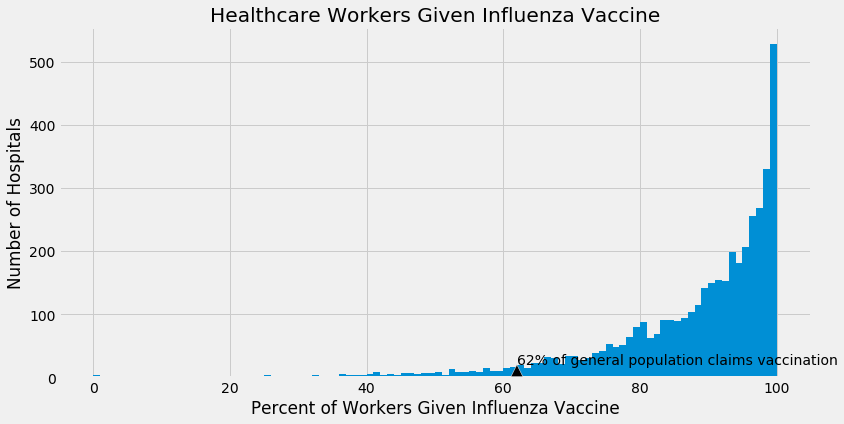

In [39]:
#standard chart for quick viz in github
hw_influenza_study.score.plot(kind='hist', bins=100, figsize=(12,6))
plt.title('Healthcare Workers Given Influenza Vaccine')
plt.ylabel('Number of Hospitals')
plt.xlabel('Percent of Workers Given Influenza Vaccine')
plt.annotate('62% of general population claims vaccination', xy=(62,20), arrowprops=dict(facecolor = 'black'));

Is the significant number of hospitals whose vaccination rates are below 90% a cause for alarm? Let's figure it out using published math models.

- [Basic Reproduction Numbers](https://en.wikipedia.org/wiki/Basic_reproduction_number) - The number of cases of a given illness one is expected to generate while infected
- [CDC Guide to Vaccination Effectiveness](https://www.cdc.gov/flu/professionals/vaccination/effectiveness-studies.htm) - Vaccine effectiveness for influenza was 40% in 2017-2018
- [Thoughtscapism Blog's Simple Math of Herd Immunity](https://thoughtscapism.com/2015/04/20/the-simple-math-of-herd-immunity/) - Formula used below

In [40]:
def vaccine_coverage(reproduction, vaccine_effectiveness):
    '''Calculates percent of population requiring vaccines by taking in the number of cases an infected individual is expected to generate
       and the effectiveness of a given vaccine'''
    
    herd_immunity_threshold = (1-(1/reproduction))
    vaccine_coverage = herd_immunity_threshold/vaccine_effectiveness
    
    return vaccine_coverage

influenza_reproduction_rate = 2.5
influenza_vaccine_effectiveness = .4

print('Percent of vaccinations needed: ' + str(vaccine_coverage(influenza_reproduction_rate, influenza_vaccine_effectiveness)*100) + '%')

Percent of vaccinations needed: 149.99999999999997%


As we can see, it's impossible to hit the herd immunity threshold against influenza, but to reduce hospital acquired infections, healthcare workers should vaccinate at far higher rates than a [general population who is doubtful of the need for vaccinations](https://www.npr.org/sections/health-shots/2015/11/27/456202280/many-americans-believe-they-dont-need-the-flu-vaccine) (NPR).

Typical curiosities at this point:
- What factors caused this number?
- What is the impact of improvements on this number?
- How can we improve this number?

Upcoming updates to this repo will explore these questions first with plotting trends in this data set, then combining other datasets to dig deeper. 